In [31]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import warnings
import torch.nn.functional as F
from torchvision.transforms import Resize, Grayscale, Normalize, Compose, RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ConvertImageDtype
warnings.filterwarnings('ignore')


In [32]:
# Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for label in ["NORMAL", "PNEUMONIA"]:
            dir_path = os.path.join(self.root_dir, label)
            self.images.extend([os.path.join(dir_path, file) for file in os.listdir(dir_path)])
            self.labels.extend([0 if label == "NORMAL" else 1 for _ in os.listdir(dir_path)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = read_image(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [33]:
# Define Hyperparameters
hyper_dimension = 224
hyper_epochs = 5
hyper_batch_size = 32
hyper_feature_maps = 32
hyper_channels = 1

# Transformation pipelines
data_transforms = Compose([
    RandomHorizontalFlip(),
    Grayscale(num_output_channels=hyper_channels),
    Resize((hyper_dimension, hyper_dimension)),
    ConvertImageDtype(torch.float),
    Normalize(mean=[0.5], std=[0.5]) 
])

data_transforms_train = Compose([
    RandomHorizontalFlip(),
    Grayscale(num_output_channels=hyper_channels),
    Resize((hyper_dimension, hyper_dimension)),
    ConvertImageDtype(torch.float),
    Normalize(mean=[0.5], std=[0.5])
])

In [34]:
train_dataset = ChestXRayDataset(root_dir='C:\\Users\\srira\\OneDrive\\Documents\\chest_xray\\train', transform= data_transforms_train)
test_dataset = ChestXRayDataset(root_dir='C:\\Users\\srira\\OneDrive\\Documents\chest_xray\\test', transform= data_transforms)
val_dataset = ChestXRayDataset(root_dir='C:\\Users\\srira\\OneDrive\\Documents\\chest_xray\\val', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=hyper_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyper_batch_size, shuffle=False)


In [35]:
def dataset_to_dataframe(dataset):
    df = pd.DataFrame({'ImagePath': dataset.images, 'Label': dataset.labels})
    df['Label'] = df['Label'].map({0: 'NORMAL', 1: 'PNEUMONIA'})
    return df

train_df = dataset_to_dataframe(train_dataset)
test_df = dataset_to_dataframe(test_dataset)
val_df = dataset_to_dataframe(val_dataset)


In [36]:
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Validation DataFrame shape:", val_df.shape)

print("\nRandom rows from Train DataFrame:")
print(train_df.sample(5))
print("\nRandom rows from Test DataFrame:")
print(test_df.sample(5))
print("\nRandom rows from Validation DataFrame:")
print(val_df.sample(5))


Train DataFrame shape: (5160, 2)
Test DataFrame shape: (624, 2)
Validation DataFrame shape: (72, 2)

Random rows from Train DataFrame:
                                              ImagePath      Label
2012  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
2629  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
3646  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
474   C:\Users\srira\OneDrive\Documents\chest_xray\t...     NORMAL
2219  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA

Random rows from Test DataFrame:
                                             ImagePath      Label
473  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
530  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
347  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
278  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA
494  C:\Users\srira\OneDrive\Documents\chest_xray\t...  PNEUMONIA

Random rows from Validation Data

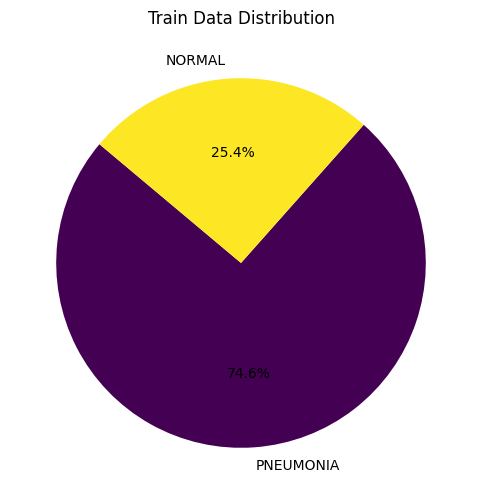

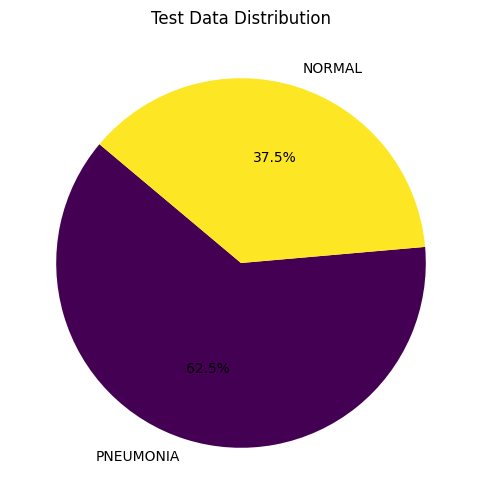

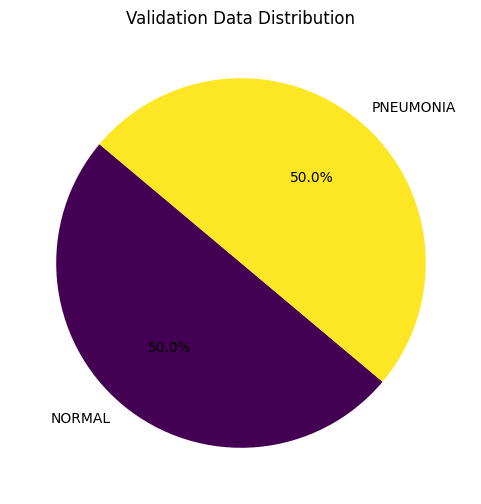

In [37]:
import numpy as np
def visualize_distribution(df, title):
    count = df['Label'].value_counts()
    colors = plt.cm.viridis(np.linspace(0, 1, len(count)))
    plt.figure(figsize=(6, 6))
    plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(title)
    plt.show()

visualize_distribution(train_df, 'Train Data Distribution')
visualize_distribution(test_df, 'Test Data Distribution')
visualize_distribution(val_df, 'Validation Data Distribution')


Training Dataset Images:


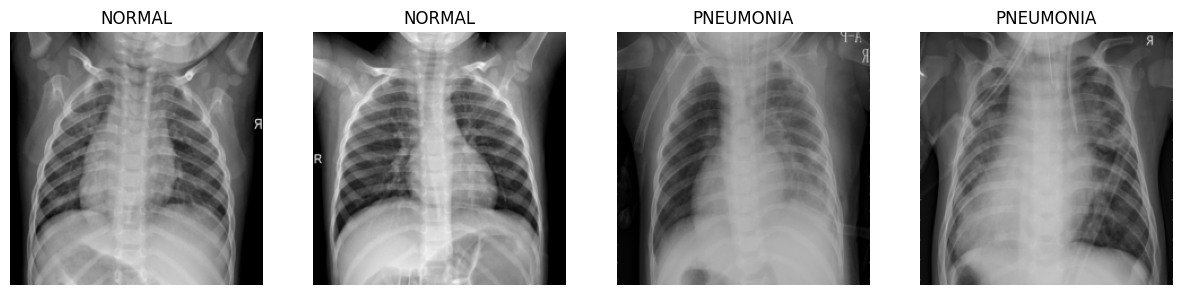

Validation Dataset Images:


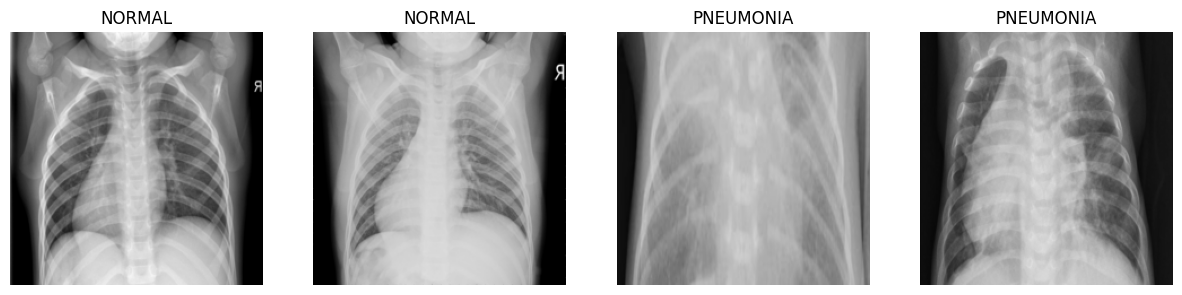

Test Dataset Images:


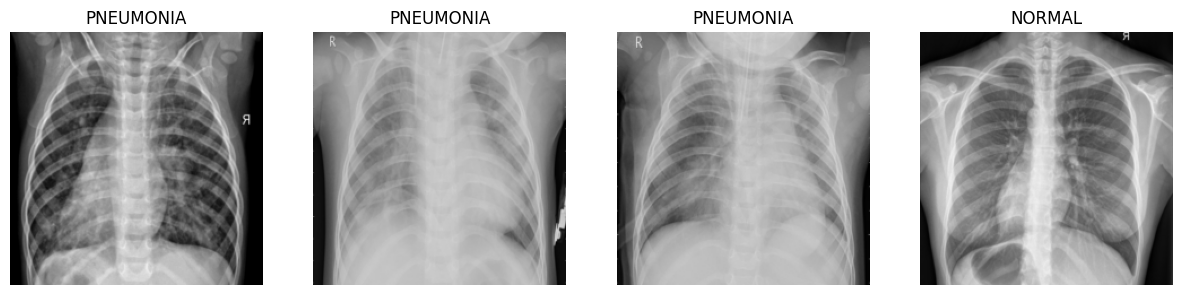

In [38]:
def show_images(dataset, num_images=4):
    # Initialize the plot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
    
    # Select random images from the dataset
    selected_indices = np.random.choice(len(dataset), size=num_images, replace=False)
    
    # Display the selected images
    for i, idx in enumerate(selected_indices):
        image, label = dataset[idx]
        
        # Convert tensor to numpy array and transpose if necessary
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose((1, 2, 0))
        
        # Convert grayscale to RGB if necessary
        if image.shape[-1] == 1:
            image = np.squeeze(image, axis=-1)
            image = np.stack((image,) * 3, axis=-1)
        
        # Rescale image from [-1, 1] to [0, 1] for display
        image = (image + 1) / 2
        
        axes[i].imshow(image)
        axes[i].set_title('NORMAL' if label == 0 else 'PNEUMONIA')
        axes[i].axis('off')
    
    plt.show()

# Display images from each dataset
print("Training Dataset Images:")
show_images(train_dataset)
print("Validation Dataset Images:")
show_images(val_dataset)
print("Test Dataset Images:")
show_images(test_dataset)

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Calculate the correct input feature size
        self.feature_size = 64 * (224 // 2 // 2 // 2) ** 2  # After three layers of halving the dimension
        self.fc1 = nn.Linear(self.feature_size, 128)  # Adjusted number of input features
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        return self.sigmoid(x)

# Instantiate the model
model = CNN()

In [40]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    # Initialize lists to track per-epoch training and validation loss, accuracy, and other metrics
    train_losses, train_accuracies, train_precisions, train_recalls, train_f1s = [], [], [], [], []
    val_losses, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_corrects = 0
        total_train = 0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.round(outputs)
            train_loss += loss.item() * images.size(0)
            train_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)
            train_preds.extend(preds.view(-1).tolist())
            train_labels.extend(labels.view(-1).tolist())

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = train_corrects.float() / total_train
        epoch_train_precision = precision_score(train_labels, train_preds)
        epoch_train_recall = recall_score(train_labels, train_preds)
        epoch_train_f1 = f1_score(train_labels, train_preds)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        train_precisions.append(epoch_train_precision)
        train_recalls.append(epoch_train_recall)
        train_f1s.append(epoch_train_f1)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        total_val = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                labels = labels.unsqueeze(1).float()
                loss = criterion(outputs, labels)

                preds = torch.round(outputs)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
                total_val += labels.size(0)
                val_preds.extend(preds.view(-1).tolist())
                val_labels.extend(labels.view(-1).tolist())

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = val_corrects.float() / total_val
        epoch_val_precision = precision_score(val_labels, val_preds)
        epoch_val_recall = recall_score(val_labels, val_preds)
        epoch_val_f1 = f1_score(val_labels, val_preds)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        val_precisions.append(epoch_val_precision)
        val_recalls.append(epoch_val_recall)
        val_f1s.append(epoch_val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        print(f'Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_acc:.4f} - Train Precision: {epoch_train_precision:.4f} - Train Recall: {epoch_train_recall:.4f} - Train F1: {epoch_train_f1:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f} - Validation Accuracy: {epoch_val_acc:.4f} - Validation Precision: {epoch_val_precision:.4f} - Validation Recall: {epoch_val_recall:.4f} - Validation F1: {epoch_val_f1:.4f}')
    
    return model, (train_losses, train_accuracies, val_losses, val_accuracies, train_precisions, train_recalls, train_f1s, val_precisions, val_recalls, val_f1s)


# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            predicted = (outputs.data > 0.5).float()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
    cm = confusion_matrix(all_labels, all_preds)
    return pd.DataFrame(cm, index=['Actual Normal', 'Actual Pneumonia'], 
                        columns=['Predicted Normal', 'Predicted Pneumonia'])


In [42]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, train_precisions, train_recalls, train_f1s, val_precisions, val_recalls, val_f1s):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_precisions, 'bo-', label='Training Precision')
    plt.plot(epochs, val_precisions, 'ro-', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_recalls, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recalls, 'ro-', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_f1s, 'bo-', label='Training F1 Score')
    plt.plot(epochs, val_f1s, 'ro-', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.show()




Epoch 1/5
----------
Train Loss: 0.2710 - Train Accuracy: 0.8973 - Train Precision: 0.9191 - Train Recall: 0.9454 - Train F1: 0.9321
Validation Loss: 0.1108 - Validation Accuracy: 0.9722 - Validation Precision: 0.9722 - Validation Recall: 0.9722 - Validation F1: 0.9722
Epoch 2/5
----------
Train Loss: 0.1027 - Train Accuracy: 0.9614 - Train Precision: 0.9713 - Train Recall: 0.9771 - Train F1: 0.9742
Validation Loss: 0.1270 - Validation Accuracy: 0.9306 - Validation Precision: 0.8974 - Validation Recall: 0.9722 - Validation F1: 0.9333
Epoch 3/5
----------
Train Loss: 0.0856 - Train Accuracy: 0.9688 - Train Precision: 0.9777 - Train Recall: 0.9805 - Train F1: 0.9791
Validation Loss: 0.1298 - Validation Accuracy: 0.9583 - Validation Precision: 0.9231 - Validation Recall: 1.0000 - Validation F1: 0.9600
Epoch 4/5
----------
Train Loss: 0.0660 - Train Accuracy: 0.9767 - Train Precision: 0.9814 - Train Recall: 0.9875 - Train F1: 0.9845
Validation Loss: 0.0494 - Validation Accuracy: 0.9861 - V

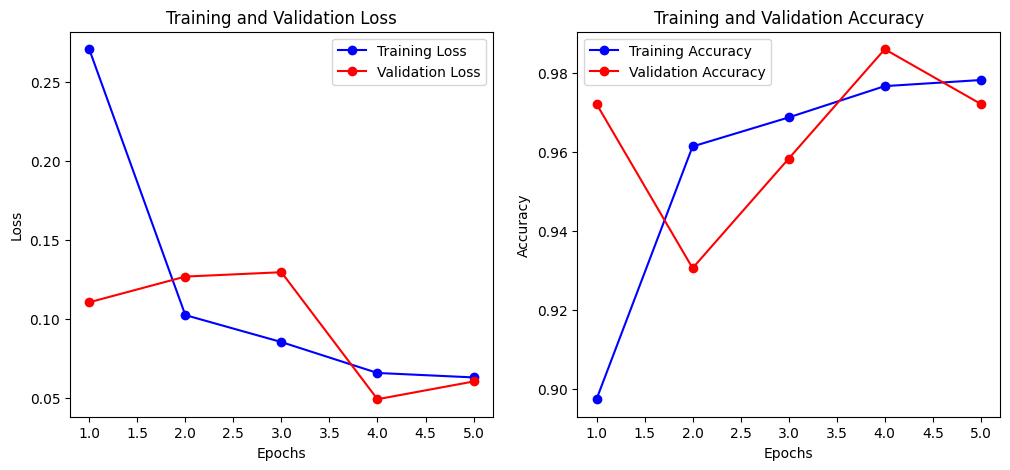

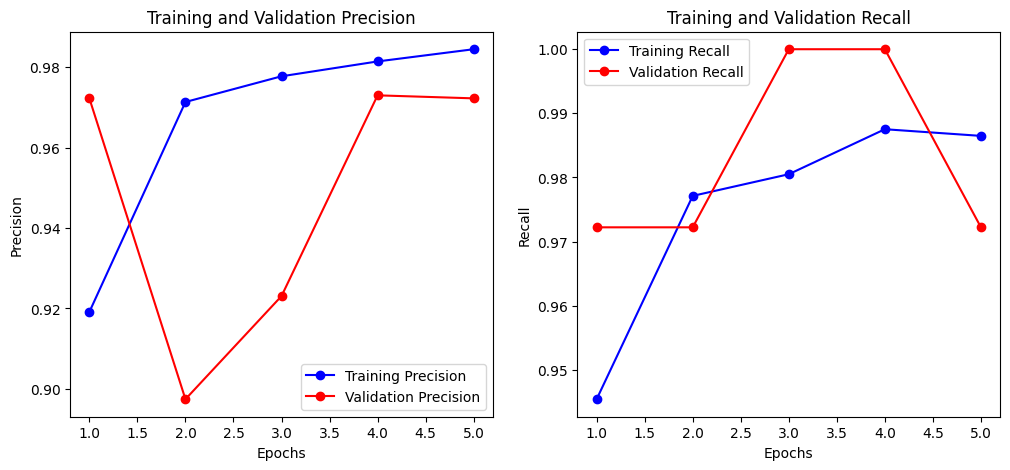

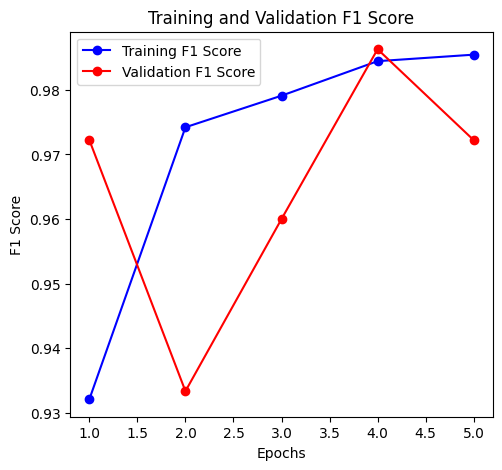

                  Predicted Normal  Predicted Pneumonia
Actual Normal                  114                  120
Actual Pneumonia                11                  379


In [43]:
model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, hyper_epochs)
train_losses, train_accuracies, val_losses, val_accuracies, train_precisions, train_recalls, train_f1s, val_precisions, val_recalls, val_f1s = metrics
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, train_precisions, train_recalls, train_f1s, val_precisions, val_recalls, val_f1s)

conf_matrix = evaluate_model(model, test_loader)
print(conf_matrix)


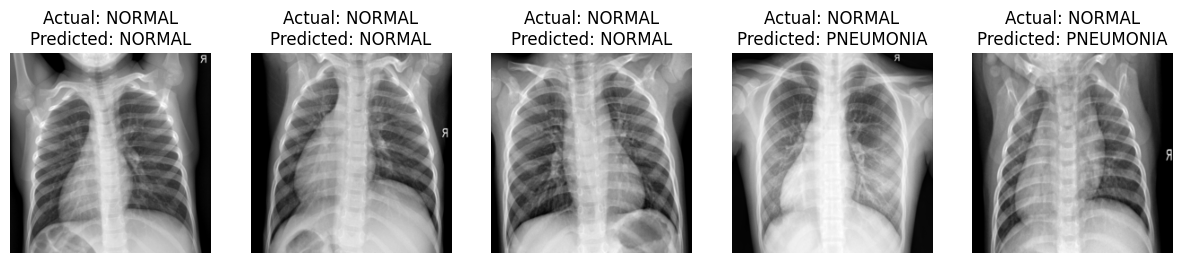

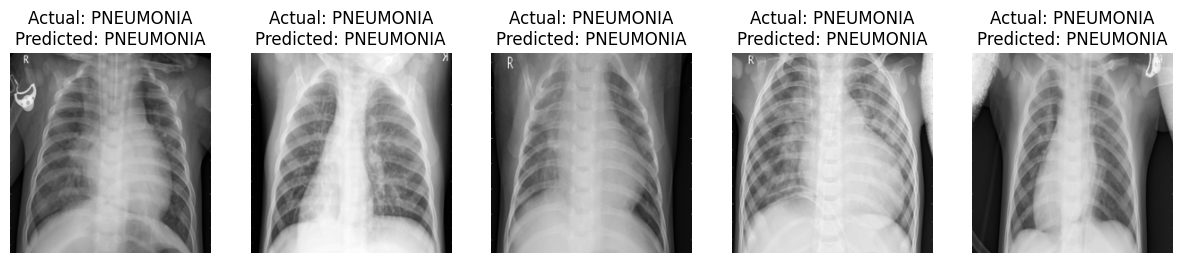

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch
import random
from torchvision.io import read_image
import os

def visualize_predictions(dataset, model, num_images=5):
    
    model.eval()
    
    transform = Compose([
    RandomHorizontalFlip(),
    #RandomVerticalFlip(),
    #RandomRotation(20),
    Grayscale(num_output_channels=hyper_channels),
    Resize((hyper_dimension, hyper_dimension)),
    ConvertImageDtype(torch.float),
    Normalize(mean=[0.5], std=[0.5]) 
    ])
    
    
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_folder = os.path.join(dataset.root_dir, class_name)
        image_files = os.listdir(class_folder)
        random_images = random.sample(image_files, num_images)
        
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        
        for i, image_file in enumerate(random_images):
            img_path = os.path.join(class_folder, image_file)
            image = read_image(img_path).float() / 255.0  
            image = transform(image).unsqueeze(0)  

            
            with torch.no_grad():
                outputs = model(image)
                predicted = outputs.round().int()  
                predicted_class = 'PNEUMONIA' if predicted.numpy()[0, 0] == 1 else 'NORMAL'

            # Display the image
            image = image.squeeze().numpy()  
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Actual: {class_name}\nPredicted: {predicted_class}')
        
        plt.show()

# Call the function
visualize_predictions(test_dataset, model)



In [45]:
def calculate_test_accuracy(test_loader, model):
    # Ensure the model is in evaluation mode
    model.eval()

    # Tracking variables
    correct = 0
    total = 0

    # No gradients needed
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)

            # Get prediction
            predicted = (outputs.data > 0.5).float().view_as(labels)  

            # Update tracking variables
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = (correct / total) * 100
    return accuracy

# Assuming 'test_loader' is already created and loaded with the test dataset
test_accuracy = calculate_test_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 79.17%
